In [5]:
# Importer des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import os
import seaborn as sns

# pour imprimer des jolies images utilisant Pandas
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

# les informations utilisées pour créer une connexion à la base de données, stockées en tant que paramètres
dbinfo = "user=postgres dbname=mimic password=postgres"

L'extraction de données commencera par l'écriture de certaines fonctions qui seront utilisées dans ce cahier.

In [14]:
def execute_query(query, dbinfo, params=None):
    """Exécute la requête sur la base de données locale.
    
     Args:
         query (string): requête sql
         dbinfo (string): chaînes de connexion, par exemple, 
         "user = postgres dbname = mimic password = postgres"
         params (dictionnaire): paramètres pour les requêtes SQL
        
     Résultats:
         Pandas dataFrame ou exception.
     """
    
    try:
        with psycopg2.connect(dbinfo) as con:
            # use pandas to read the query
            df = pd.read_sql_query(query, con, params=params)
            return df
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        
def get_path(filename, suffix):
    """Retourne le chemin
    
     Args:
         filename (string): nom du fichier
         suffix (string): extension du fichier
        
     Résultats:
         chemin
     """
# Créer le chemin pour le fichier
    cwd = os.getcwd()
    dir_name = os.path.join(cwd, 'data')
    
    return os.path.join(dir_name, filename + "." + suffix)
        
def save_to_csv(df, path):
    """Sauvegarde la donnée extraite dans le fichier csv sous le dossier" data ".
    
     Args:
         df (Pandas Dataframe): la base de données devait être sauvegardée
         filename (string): nom du fichier
        
     Résultats:
         Aucun
     """
    dir_name, filename = os.path.split(path)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
     
    df.to_csv(path)

D'abord, nous pouvons plonger et obtenir une liste de toutes les tables dans MIMIC-III. Il devrait y avoir 26 tables dans la base de données sous le nom de schéma "mimiciii" (https://mimic.physionet.org/).

In [17]:
query = """select * from pg_tables where schemaname='mimiciii' and hasindexes"""

# obtenir les tables
tables = execute_query(query, dbinfo)

print("Taille de la table:", tables.shape, "\n")

print("Les 5 premières lignes de la table sont:")
tables.head()

Taille de la table: (43, 8) 

Les 5 premières lignes de la table sont:


,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,mimiciii,chartevents_1,postgres,None,True,False,False,False
1,mimiciii,chartevents_2,postgres,None,True,False,False,False
2,mimiciii,chartevents_3,postgres,None,True,False,False,False
3,mimiciii,chartevents_4,postgres,None,True,False,False,False
4,mimiciii,chartevents_5,postgres,None,True,False,False,False


Puisque nous nous concentrons sur les tables sous le nom de schéma "mimiciii", nous établissons un chemin de recherche pour plus de commodité.

In [8]:
# schema name for setting a search path
schema_name = 'mimiciii'
query_schema = 'set search_path to ' + schema_name + ';'

In [9]:
# les paramètres passeront à la requête SQL Pandas
cohort_params = {'year': 60.0*60.0*24.0*365.242, 'minage': 16, 'minstay': 1, 'maxstay': 10}

cohort_query = query_schema + """
-- t0 est généré à partir de la table 'icustays'
WITH t0 AS
(
    SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
    , round(cast(extract('epoch' from icu.intime - pat.dob)/%(year)s as numeric),2) AS age          -- calculate the age 
    , round(cast(icu.los as numeric),2) as los
    , RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_order                -- rank the ICU admission
    , CASE                                                                                          -- Age < 16 --> 0
        WHEN round(cast(extract('epoch' from icu.intime - pat.dob)/%(year)s as numeric),2) < %(minage)s THEN 1 
        ELSE 0 END AS excl_age                                                                      
    , CASE                                                                                          -- 1 <=Length <= 10 --> 0
        WHEN (icu.los BETWEEN %(minstay)s AND %(maxstay)s) THEN 0 ELSE 1 END AS excl_los            
    , CASE                                                                                          -- first ICU admission --> 0
        WHEN RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) != 1 THEN 1              
        ELSE 0 END AS excl_icustay
    FROM icustays icu INNER JOIN patients pat ON icu.subject_id = pat.subject_id
)
-- t1 est généré à partir de la table "admissions"
, t1 AS
(
    SELECT adm.admission_type, adm.hadm_id, adm.has_chartevents_data
    , CASE                                                                                          -- exclude NEWBORN/ELECTIVE cases 
        WHEN admission_type IN ('EMERGENCY', 'URGENT') THEN 0                                       
        ELSE 1 END AS excl_plan
    , CASE
        WHEN adm.has_chartevents_data = 1 then 0 else 1 end as excl_chartevents
    FROM admissions as adm
)
SELECT
-- les attributs
t0.subject_id, t0.hadm_id, t0.icustay_id, t0.age, t0.los, 
t1.admission_type, t1.has_chartevents_data,

-- exclusions
t0.icustay_order, t0.excl_age, t0.excl_los, t0.excl_icustay, 
t1.excl_plan, t1.excl_chartevents

FROM t0 INNER JOIN t1 ON t0.hadm_id = t1.hadm_id 
"""
#icustay_id is the primary key in cohort table
cohort_table = execute_query(cohort_query, dbinfo, params=cohort_params)

print("Dimensions de la table de cohorte:", cohort_table.shape)

cohort_table.head()

Dimensions de la table de cohorte: (61532, 13)


,subject_id,hadm_id,icustay_id,age,los,admission_type,has_chartevents_data,icustay_order,excl_age,excl_los,excl_icustay,excl_plan,excl_chartevents
0,58526,100001,275225,35.48,4.26,EMERGENCY,1,1,0,0,0,0,0
1,54610,100003,209281,59.91,1.94,EMERGENCY,1,1,0,0,0,0,0
2,9895,100006,291788,48.92,4.98,EMERGENCY,1,1,0,0,0,0,0
3,23018,100007,217937,73.82,4.10,EMERGENCY,1,1,0,0,0,0,0
4,533,100009,253656,60.80,2.49,EMERGENCY,1,1,0,0,0,0,0


Puisque toutes les exclusions sont énumérées dans le tableau, les critères d'exclusion sont clairement énoncés. Nous résumons la sélection de la cohorte en totalisant les statistiques.

Condition:                valeur(%)
Total des observations    61532 (100.00%)
excl_age                   8109 (13.18%)
excl_los                  19089 (31.02%)
excl_icustay              15056 (24.47%)
excl_plan                 15331 (24.92%)
excl_chartevents            481 (0.78%)

Total exclu               37495 (60.94%)
Total inclu               24037 (39.06%)


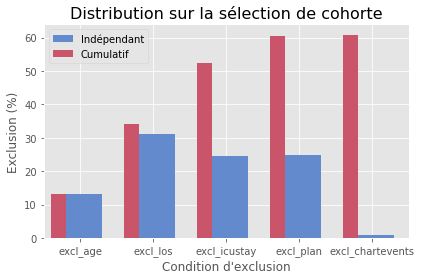

In [10]:
# imprimer les deux premières lignes
print( '{:25s} {:5s}'.format('Condition:', 'valeur(%)') )
print( '{:25s} {:5d} ({:2.2f}%)'.format('Total des observations', cohort_table.shape[0], 100))

# créer une liste booléenne avec df.shape [0] comme index d'exclusion
idxExcl = np.zeros(cohort_table.shape[0],dtype=bool) 

# créer un dictionnaire pour stocker les données
excl_contribution = []
excl_cumulative_sum = []
columns = []

# calcule le pourcentage d'exclusion pour chaque condition
for col in cohort_table.columns:
    if "excl_" in col:
        columns.append(col) 
        count = cohort_table[col].sum()
        contribution = count*100.0/cohort_table.shape[0]
        print('{:25s} {:5d} ({:2.2f}%)'.format(col, count, contribution))
        idxExcl = (idxExcl) | (cohort_table[col]==1) # au niveau du bit ou
        cumulative_sum = idxExcl.sum() # compter la somme cumulée des cas d'exclusion
        excl_contribution.append(contribution)
        excl_cumulative_sum.append(cumulative_sum/cohort_table.shape[0]*100)
        
# imprimer un résumé du nombre d'observations exclues en fonction des contraintes données
print('')
print('{:25s} {:5d} ({:2.2f}%)'.format('Total exclu', np.sum(idxExcl), np.sum(idxExcl)*100.0/cohort_table.shape[0]))
print('{:25s} {:5d} ({:2.2f}%)'.format('Total inclu', cohort_table.shape[0] - np.sum(idxExcl), 
                                       100 - np.sum(idxExcl)*100.0/cohort_table.shape[0]))

# créer un graphique pour montrer l'exclusion
def cohort_plot(contribution, cumulative_sum, columns):
    """
    
     Afficher la sélection de cohrt.
    
     contributions:
       - contirbution: (liste) la liste de la contribution indepdente de la condition donnée sur l'exclusion
       - cumulative_sum: (liste) la liste de la somme cumulée des conditions données sur l'exclusion
       - colonnes: (liste) la liste des noms
     
    """
    # Nombre de barres
    n = len(contribution)
    
    # Créer le graphique
    fig = plt.figure(figsize = (6,4))
    
    plt.title("Distribution sur la sélection de cohorte", fontsize = 16)
    plt.bar(np.arange(n), contribution, width = 0.6, align="center", color = '#648ace', \
          label = "Indépendant")
    plt.bar(np.arange(n) - 0.3, cumulative_sum, width = 0.2, align = "center", color = '#ca556a', \
          label = "Cumulatif")
    plt.xticks(np.arange(n), columns)
    plt.xlim((-0.5, n-0.5))
    plt.ylabel("Exclusion (%)", fontsize = 12)
    plt.xlabel("Condition d'exclusion", fontsize = 12)
    plt.legend(loc = 'upper left')
    if not os.path.exists('plot'):
        os.makedirs('plot')
    plt.savefig('plot/distribution_sélection_cohorte')
    
    plt.tight_layout()
    plt.show() 
    
cohort_plot(excl_contribution, excl_cumulative_sum, columns)

Au total, environ 61% des patients sont exclus pour les raisons que nous avons mentionnées. Nous pouvons maintenant obtenir les identifiants de séjour de la cohorte, qui seront utilisés pour l'exploration et l'analyse des données.

In [11]:
# rejoindre toutes les conditions d'exclusion
conditions = (cohort_table['excl_age']==0) & (cohort_table['excl_los']==0) \
                 & (cohort_table['excl_icustay']==0) & (cohort_table['excl_plan']==0) \
                 & (cohort_table['excl_chartevents']==0)

# Sélectionnez la cohorte en fonction des conditions de jointure donnant
cohort = cohort_table[conditions]

# obtenir les cohortID
cohortIDs = tuple([x for x in cohort['icustay_id']]) # cast to integer
print( 'Total des observations dans la cohorte:', cohort.shape[0])
cohort.head()

Total des observations dans la cohorte: 24037


,subject_id,hadm_id,icustay_id,age,los,admission_type,has_chartevents_data,icustay_order,excl_age,excl_los,excl_icustay,excl_plan,excl_chartevents
0,58526,100001,275225,35.48,4.26,EMERGENCY,1,1,0,0,0,0,0
1,54610,100003,209281,59.91,1.94,EMERGENCY,1,1,0,0,0,0,0
2,9895,100006,291788,48.92,4.98,EMERGENCY,1,1,0,0,0,0,0
3,23018,100007,217937,73.82,4.10,EMERGENCY,1,1,0,0,0,0,0
4,533,100009,253656,60.80,2.49,EMERGENCY,1,1,0,0,0,0,0


Démographie de la cohorte
Les détails généraux des patients peuvent être extraits des tableaux: patients et icustays. Le sexe, l'âge, le temps, le temps passé, la durée du séjour et la survie sont considérés. De plus, le décès à l'hôpital est également calculé.

In [20]:
# définir les paramètres
params = {'year': 60.0*60.0*24.0*365.242, 'day': 60.0*60.0*24.0, 'cohortIDs':cohortIDs}

# écrire la requête
query = query_schema + """
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, pat.gender, icu.dbsource
, ROUND(CAST(EXTRACT(epoch FROM icu.intime - pat.dob)/%(year)s AS numeric),2) AS age
, icu.intime
, round(cast(extract(epoch from adm.dischtime - icu.intime)/%(day)s as numeric), 2) as los
, case 
    when (pat.dod is not null) 
    then round(cast(extract(epoch from pat.dod - icu.intime)/%(day)s as numeric), 2) 
    else -1 end as survival
, case 
    when round(cast(extract(epoch from adm.dischtime - icu.intime)/%(day)s as numeric), 2)
         >= round(cast(extract(epoch from pat.dod - icu.intime)/%(day)s as numeric), 2) 
    then 1 else 0 end as in_hospital_death
FROM icustays icu
INNER JOIN patients pat ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm on adm.hadm_id = icu.hadm_id
WHERE icu.icustay_id in %(cohortIDs)s
ORDER BY icu.subject_id, icu.intime;
"""
# exécuter la requête
patient_details = execute_query(query, dbinfo, params=params)
print("Dimensions de la table des détails des patients:", patient_details.shape)

patient_details.head()

Dimensions de la table des détails des patients: (24037, 10)


,subject_id,hadm_id,icustay_id,gender,dbsource,age,intime,los,survival,in_hospital_death
0,3,145834,211552,M,carevue,76.53,2101-10-20 19:10:11,10.78,236.20,0
1,4,185777,294638,F,carevue,47.85,2191-03-16 00:29:31,7.76,-1.00,0
2,9,150750,220597,M,carevue,41.79,2149-11-09 13:07:02,4.88,4.45,1
3,11,194540,229441,F,carevue,50.15,2178-04-16 06:19:32,25.53,211.74,0
4,13,143045,263738,F,carevue,39.87,2167-01-08 18:44:25,6.85,-1.00,0


Pour protéger la confidentialité du patient, toutes les dates dans la base de données ont été décalées. De plus, la date de naissance du patient a été décalée avant l'année 1900 si le patient est âgé de plus de 89 ans. Dans ces cas, l'âge du patient à la première admission a été fixé à 300 ans. L'âge médian pour ce groupe de patients est de 91,4 (https://mimic.physionet.org/mimictables/patients/). Par conséquent, l'âge des patients de plus de 89 ans est remplacé par la médiane, qui est de 91,4 ans.

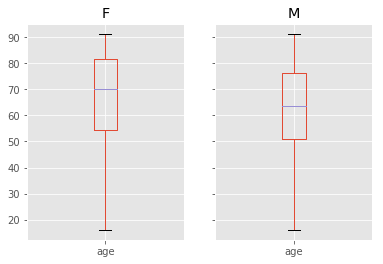

In [21]:
# identifier le groupe dans lequel leurs âges sont décalés
shifted_age = patient_details['age'] >= 300

# remplacer l'âge avec 91,4
patient_details.loc[shifted_age, 'age'] = 91.4

# diagramme en boîte
age_bplot = patient_details[['gender','age']].groupby('gender').boxplot(return_type='axes')

Dans la section suivante, la taille et le poids moyens des patients sont extraits des tableaux: charttime et icustay. La requête SQL est modifiée à partir de la requête SQL à partir du code dans GitHub.

In [22]:
# the query to get the height and weight
query = query_schema + """
with rawdata as 
    ( -- extraction, transformation et nettoyage de données
    SELECT c.charttime, c.itemid,c.subject_id, c.icustay_id,
    CASE
        WHEN c.itemid IN (762, 763, 3723, 3580, 3581, 3582, 226512) THEN 'WEIGHT'
        WHEN c.itemid IN (920, 1394, 4187, 3486, 3485, 4188, 226707) THEN 'HEIGHT'
    END AS category,
    -- Assurer que tous les poids sont en kg et que les hauteurs sont en centimètres
    CASE
        WHEN c.itemid IN (3581, 226531) THEN c.valuenum * 0.45359237            -- lb en kg
        WHEN c.itemid IN (3582) THEN c.valuenum * 0.0283495231                  -- once en kg
        WHEN c.itemid IN (920, 1394, 4187, 3486, 226707) THEN c.valuenum * 2.54 -- in en cm
        ELSE c.valuenum
    END AS valuenum
    FROM chartevents c
        WHERE c.icustay_id in %(cohortIDs)s
              AND c.valuenum IS NOT NULL
              -- exclude rows marked as error
              AND c.error IS DISTINCT FROM 1 -- not 1
              AND c.itemid IN (-- Carevue
                                762, 763, 3723, 3580,                     -- Poids Kg
                                3581,                                     -- Poids lb
                                3582,                                     -- Poids oz
                                920, 1394, 4187, 3486,                    -- taille inches
                                3485, 4188,                               -- taille cm
                                -- Metavision
                                226707,                                   -- taille, cm
                                226512)                                   -- Poids d'admission(Kg) 
              AND c.valuenum <> 0
    )
, singlefeature as 
    ( -- feature selection
    SELECT distinct subject_id, icustay_id, category,
    avg(valuenum) over
        (partition BY subject_id, icustay_id, category
         order by charttime ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS avg_valuenum
    FROM rawdata order by subject_id, icustay_id, category
    )
, pivotfeatures AS 
    (
    SELECT subject_id, icustay_id,
    MAX(case when category = 'HEIGHT' then avg_valuenum else NULL end) AS height_avg,
    MAX(case when category = 'WEIGHT' then avg_valuenum else NULL end) AS weight_avg
    FROM singlefeature GROUP BY subject_id, icustay_id
    )
    
SELECT f.icustay_id, f.subject_id,
ROUND(cast(f.height_avg as numeric),1) AS height_avg,
ROUND(cast(f.weight_avg as numeric),1) AS weight_avg
FROM pivotfeatures f ORDER BY subject_id, icustay_id;
"""

patient_weightheight = execute_query(query, dbinfo, params=params)
patient_weightheight.head()

,icustay_id,subject_id,height_avg,weight_avg
0,211552,3,179.1,101.9
1,294638,4,NaN,53.6
2,220597,9,182.9,102.9
3,263738,13,144.8,73.6
4,217847,21,175.3,65.3


Ensuite, la relation poids / taille du patient est concaténée dans la relation détail patient. La relation résultante est enregistrée pour une utilisation future.

In [11]:
# Pour concaténer les tables patient_details et patient_weightheight
cols_to_use = patient_weightheight.columns.difference(patient_details.columns)
patient_details = pd.concat([patient_details, patient_weightheight[cols_to_use]], axis=1)

# Pour enregistrer l'élément de données dans 'patient_details'
file_path = get_path('patient_details', 'csv')
if not os.path.exists('data'):
    os.makedirs('data')
save_to_csv(patient_details, file_path)
print("Dimensions de la table concaténée :", patient_details.shape)

# Afficher la table concaténée 
patient_details.head()

Dimensions de la table concaténée : (24037, 12)


,subject_id,hadm_id,icustay_id,gender,dbsource,age,intime,los,survival,in_hospital_death,height_avg,weight_avg
0,3,145834,211552,M,carevue,76.53,2101-10-20 19:10:11,10.78,236.20,0,179.1,101.9
1,4,185777,294638,F,carevue,47.85,2191-03-16 00:29:31,7.76,-1.00,0,NaN,53.6
2,9,150750,220597,M,carevue,41.79,2149-11-09 13:07:02,4.88,4.45,1,182.9,102.9
3,11,194540,229441,F,carevue,50.15,2178-04-16 06:19:32,25.53,211.74,0,144.8,73.6
4,13,143045,263738,F,carevue,39.87,2167-01-08 18:44:25,6.85,-1.00,0,175.3,65.3


Mesures physiologiques:
Les mesures physiologiques liées au score de SAPS-II ont été choisies pour caractériser l'état du patient. Ces mesures sont: fréquence cardiaque, pression artérielle systolique, fréquence respiratoire, température, GCS, urine, nombre de globules blancs, azote uréique sanguin, potassium, sodium, bicarbonate, pression partielle d'oxygène et fraction d'oxygène inspiré.
La fréquence cardiaque, la fréquence respiratoire, la pression artérielle systolique, la GCS et la température sont enregistrées dans le tableau des caractéristiques. La sortie d'urine est enregistrée dans la table outputevents. Les globules blancs, l'azote uréique du sang, le potassium, le sodium, le bicarbonate, la pression partielle d'oxygène et la fraction d'oxygène inspiré sont enregistrés dans le tableau des laves.
Nous commençons l'extraction des données de la table chartevents. La mesure est échantillonnée de manière irrégulière lorsque le patient est en réanimation, mais nous considérons uniquement les données générées à partir du premier jour de séjour en unité de soins intensifs car il est plus important d'identifier le patient à haut risque dans son séjour précoce en réanimation.

In [12]:
# définir les paramètres : les élements  en chartevents, outputevents, et labevents sont considérés
# les données du graphique ont deux sources, carevue et métavision. Les deux sont considérés.
params = {'chartitems':(211,     # Heart rate
                     220045,     # Heart rate
                         51,     # Arterial BP [Systolic]
                        442,     # Manual BP [Systolic]
                        455,     # NBP [Systolic]
                       6701,     # Arterial BP [Systolic]
                     220179,     # Non Invasive Blood Pressure systolic
                     220050,     # Arterial Blood Pressure systolic
                        676,     # Temperature C 
                        677,     # Temperature C 
                        678,     # Temperature F 
                        679,     # Temperature F calc 
                     223762,     # Temperature C 
                     223761,     # Temperature F 
                        723,     # GCSVerbal
                        454,     # GCSMotor
                        184,     # GCSEyes
                     223900,     # GCS - Verbal Response
                     223901,     # GCS - Motor Response
                     220739,     # GCS - Eye Opening
                        618,     # Respiratory Rate
                        615,     # Resp Rate (Total)
                     220210,     # Respiratory Rate
                     224690      # Respiratory Rate (Total)
                       ),
              'outputitems':(
                        40055, # "Urine Out Foley"
                        43175, # "Urine ."
                        40069, # "Urine Out Void"
                        40094, # "Urine Out Condom Cath"
                        40715, # "Urine Out Suprapubic"
                        40473, # "Urine Out IleoConduit"
                        40085, # "Urine Out Incontinent"
                        40057, # "Urine Out Rt Nephrostomy"
                        40056, # "Urine Out Lt Nephrostomy"
                        40405, # "Urine Out Other"
                        40428, # "Urine Out Straight Cath"
                        40086, # Urine Out Incontinent
                        40096, # "Urine Out Ureteral Stent #1"
                        40651, # "Urine Out Ureteral Stent #2"
                        226559, # "Foley"
                        226560, # "Void"
                        226561, # "Condom Cath"
                        226584, # "Ileoconduit"
                        226563, # "Suprapubic"
                        226564, # "R Nephrostomy"
                        226565, # "L Nephrostomy"
                        226567, # Straight Cath
                        226557, # R Ureteral Stent
                        226558, # L Ureteral Stent
                        227489  # GU Irrigant/Urine Volume Out
                       ), 
          'labitems':(
                      51300, # WBC
                      51301, # WBC
                      51006, # BUN
                      50822, # Potassium
                      50971, # Potassium
                      50983, # Sodium
                      50824, # Sodium
                      50882, # HCO3
                      50821, # PO2
                      50816, # FIO2
                      50885  # 'BILIRUBIN'
    ),
          'cohortIDs': cohortIDs}

Extraction de données de la table chartevents

In [20]:
query = query_schema + """
with cohort as
( -- select the ICU stay IDs of the cohort
select icu.icustay_id, icu.intime FROM icustays icu 
where icu.icustay_id in %(cohortIDs)s
), rawdata as
(-- only the data in the first day of ICU stay is considered
select c.icustay_id, cohort.intime, c.charttime,  
cast(c.charttime - cohort.intime as interval) as time,
c.itemid, c.valuenum  
from chartevents c inner join cohort on cohort.icustay_id = c.icustay_id
where c.charttime between cohort.intime and cohort.intime + INTERVAL '1 day'
    and c.itemid in %(chartitems)s
    and c.valuenum IS NOT NULL
    and c.error IS DISTINCT FROM 1
    --and c.valuenum <> 0.0
), combination as
(-- combine data
select rd.icustay_id, rd.intime, rd.time, rd.itemid,
case
    when rd.itemid in (211, 220045) then 'heart rate' 
    when rd.itemid in (51, 442, 455, 6701, 220179, 220050) then 'sys_BP' 
    when rd.itemid in (723, 223900, 454, 223901, 184, 220739) then 'GCS'
    when rd.itemid in (223762, 676, 677, 223761, 678, 679) then 'temperature'
    when rd.itemid in (618, 615, 220210, 224690) then 'resp_rate'
    --when rd.itemid in (646, 220277) then 'spO2'
end as category,
case 
    when rd.itemid in (223762, 676, 677) and rd.valuenum > 20 and rd.valuenum < 45 then rd.valuenum
    when rd.itemid in (223761, 678, 679) and rd.valuenum > 68 and rd.valuenum < 113 then (rd.valuenum - 32)*5/9.0 -- fahrenheit to celsius
    when rd.itemid in (211, 220045) and rd.valuenum > 0 and rd.valuenum < 250 then rd.valuenum
    when rd.itemid in (51, 442, 455, 6701, 220179, 220050) and rd.valuenum > 0 and rd.valuenum < 400 then rd.valuenum
    when rd.itemid in (723, 223900, 454, 223901, 184, 220739) and rd.valuenum >= 1 and rd.valuenum <= 6 then rd.valuenum
    when rd.itemid in (618, 615, 220210, 224690) and rd.valuenum > 0 and rd.valuenum < 70 then rd.valuenum 
    else null
end as valuenum
from rawdata rd
where rd.itemid in %(chartitems)s
)
select comb.icustay_id, comb.intime, comb.time, comb.category, 
round(cast(avg(comb.valuenum) as numeric),2) as valuenum
from combination comb group by comb.icustay_id, comb.intime, comb.time, comb.category
order by comb.icustay_id, comb.intime, comb.time, comb.category
"""        

# Exécuter la requête
chartdata = execute_query(query, dbinfo, params=params)

# Enregistrer les données au format CSV
file_path = get_path('chartdata', 'csv')
if not os.path.exists('data'):
    os.makedirs('data')
save_to_csv(chartdata, file_path)

# Afficher les premières lignes du dataframe
chartdata.head()

,icustay_id,intime,time,category,valuenum
0,200003,2199-08-02 19:50:04,00:09:56,GCS,5.0
1,200003,2199-08-02 19:50:04,00:09:56,heart rate,119.0
2,200003,2199-08-02 19:50:04,00:09:56,resp_rate,35.0
3,200003,2199-08-02 19:50:04,00:09:56,sys_BP,91.0
4,200003,2199-08-02 19:50:04,01:09:56,heart rate,122.0


Extraction de données à partir de la table labevents

In [21]:
query = query_schema + """
with cohort as
(-- sélectionnez les ID de séjour de l'unité de soins intensifs de la cohorte

select icu.icustay_id, icu.hadm_id, icu.intime FROM icustays icu 
where icu.icustay_id in %(cohortIDs)s
), rawdata as
(
select cohort.icustay_id, cohort.intime, lab.charttime,  
cast(lab.charttime - cohort.intime as interval) as time,
lab.itemid, lab.valuenum  
from labevents lab inner join cohort on cohort.hadm_id = lab.hadm_id
where lab.charttime between (cohort.intime - interval '6' hour) and cohort.intime + INTERVAL '1 day'
    and lab.itemid in %(labitems)s
    and lab.valuenum IS NOT NULL
    --and lab.valuenum <> 0.0
), combination as
(
select rd.icustay_id, rd.intime, rd.time, rd.itemid,
case
    -- when rd.itemid in (50820) then 'pH' 
    when rd.itemid in (51300, 51301) then 'WBC' 
    when rd.itemid in (51006) then 'BUN'
    when rd.itemid in (50822, 50971) then 'potassium'
    when rd.itemid in (50983, 50824) then 'sodium'
    when rd.itemid in (50882) then 'HCO3'
    when rd.itemid in (50821) then 'PO2'
    when rd.itemid in (50816) then 'FIO2'
    when rd.itemid in (50885) then 'BILIRUBIN'
end as category, 
case 
    when rd.itemid in (51300, 51301) and rd.valuenum > 0 and rd.valuenum < 1000 then rd.valuenum
    when rd.itemid in (51006) and rd.valuenum > 0 and rd.valuenum < 300 then rd.valuenum
    when rd.itemid in (50822, 50971) and rd.valuenum > 0 and rd.valuenum < 30 then rd.valuenum
    when rd.itemid in (50983, 50824) and rd.valuenum > 0 and rd.valuenum < 200 then rd.valuenum
    when rd.itemid in (50882) and rd.valuenum > 0 and rd.valuenum < 10000 then rd.valuenum
    when rd.itemid in (50821) and rd.valuenum > 0 and rd.valuenum < 800 then rd.valuenum
    when rd.itemid in (50816) and rd.valuenum > 0 and rd.valuenum < 100 then rd.valuenum
    when rd.itemid in (50885) and rd.valuenum < 150 then rd.valuenum
else null end as valuenum
from rawdata rd
where rd.itemid in %(labitems)s
)
select comb.icustay_id, comb.intime, comb.time, comb.category, 
round(cast(avg(comb.valuenum) as numeric),2) as valuenum
from combination comb group by comb.icustay_id, comb.intime, comb.time, comb.category
order by comb.icustay_id, comb.intime, comb.time, comb.category
"""        
# Exécuter la requête
labdata = execute_query(query, dbinfo, params=params)
    
# Enregistrer les données au format CSV
file_path = get_path('labdata', 'csv')
if not os.path.exists('data'):
    os.makedirs('data')
save_to_csv(labdata, file_path)

# Imprimer les premières lignes de données
labdata.head()

,icustay_id,intime,time,category,valuenum
0,200003,2199-08-02 19:50:04,-1 days +21:49:56,BILIRUBIN,3.5
1,200003,2199-08-02 19:50:04,-1 days +21:49:56,BUN,21.0
2,200003,2199-08-02 19:50:04,-1 days +21:49:56,HCO3,23.0
3,200003,2199-08-02 19:50:04,-1 days +21:49:56,WBC,14.8
4,200003,2199-08-02 19:50:04,-1 days +21:49:56,potassium,3.1


In [19]:
print(labdata)

        icustay_id              intime              time   category  valuenum
0           200003 2199-08-02 19:50:04 -1 days +21:49:56  BILIRUBIN       3.5
1           200003 2199-08-02 19:50:04 -1 days +21:49:56        BUN      21.0
2           200003 2199-08-02 19:50:04 -1 days +21:49:56       HCO3      23.0
3           200003 2199-08-02 19:50:04 -1 days +21:49:56        WBC      14.8
4           200003 2199-08-02 19:50:04 -1 days +21:49:56  potassium       3.1
5           200003 2199-08-02 19:50:04 -1 days +21:49:56     sodium     140.0
6           200003 2199-08-02 19:50:04          05:56:56  BILIRUBIN       3.4
7           200003 2199-08-02 19:50:04          05:56:56        BUN      20.0
8           200003 2199-08-02 19:50:04          05:56:56       HCO3      18.0
9           200003 2199-08-02 19:50:04          05:56:56        WBC      40.2
10          200003 2199-08-02 19:50:04          05:56:56  potassium       3.2
11          200003 2199-08-02 19:50:04          05:56:56     sod

Extraire le SAPS-II

In [17]:
query = query_schema + """
select icustay_id, sapsii_prob
from SAPSII where icustay_id in %(cohortIDs)s
"""        

# Exécuter la requête
sapsii = execute_query(query, dbinfo, params=params)

# Enregistrer les données SAPS-II
file_path = get_path('sapsii_score', 'csv')
if not os.path.exists('data'):
    os.makedirs('data')
save_to_csv(sapsii, file_path)

# Afficher les premières lignes des données
sapsii.head()

,icustay_id,sapsii_prob
0,200003,0.106398
1,200007,0.029295
2,200014,0.305597
3,200019,0.552904
4,200021,0.326364
